In [1]:
import os
import datetime
import math
from collections import defaultdict
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
from selenium.webdriver.common.keys import Keys
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
sns.set()
%matplotlib inline


### Function To Read Data for a given stock name

In [2]:
def read_data_for_stock(stock_name, path_to_data):
    path_pickle =  path_to_data + stock_name +'.pk'
    return pd.read_pickle(path_pickle)

### Function To Read Data for a given list of stock name

In [3]:
def read_data_for_list_of_stocks(list_of_stocks, path_to_data):
    res = {}
    for stock in list_of_stocks:
        res[stock] = read_data_for_stock(stock, path_to_data)
    return res

### Read all the data

In [4]:
# Read data is in a dictionary format Key = stock_name, value = pandas dataframe for the read data
path = os.getcwd() + '/../data/'
data = read_data_for_list_of_stocks(['google', 'facebook', 'amazon', 'apple', 'netflix'], path)


### Read the data representing market i.e. SP500

In [5]:
sp_df = pd.read_pickle(path + 'sp500.pk')

### Function to find pct change in the stock value with market data

In [6]:
def get_pct_change_with_join(stock_df, sp500_df):
    df_Adjt_Close = pd.merge(stock_df, sp500_df, on='Date', how='inner')
    df_Adjt_Close_2 = df_Adjt_Close.filter(['Adj Close**_x','Adj Close**_y'], axis =1)
    df_Adjt_Close_2['Adj Close**_y_int'] = df_Adjt_Close_2['Adj Close**_y'].str.replace(',','').astype(float)
    df_Adjt_Close_2['Adj Close**_x_int']= df_Adjt_Close_2['Adj Close**_x'].str.replace(',','').astype(float)
    df_Adjt_Close_2 = df_Adjt_Close_2.drop(['Adj Close**_x','Adj Close**_y'], axis =1)
    df_pct_change = df_Adjt_Close_2.pct_change(1)
    df_pct_chg_no_na = df_pct_change.dropna(axis=0)
    return df_pct_chg_no_na

### Function to fit CAPM model
CAPM equation states:
Expected Return = Risk Free Return + Beta * Market Risk Premium


In [7]:
def apply_capm(df_pct_chg_no_na):
    X = df_pct_chg_no_na['Adj Close**_y_int']
    y = df_pct_chg_no_na['Adj Close**_x_int']

    #Add a constant to the independent value
    X1 = sm.add_constant(X)

    # make regression model 
    model = sm.OLS(y, X1)

    # fit model and print results
    results = model.fit()
    print(results.summary())

# Fama-French Model

### Function to apply Fama French for a stock based on fama factors

In [8]:
def prepare_for_fama_french(df_fama, nt_df):
    nt_df['Date1'] = pd.to_datetime(nt_df['Date'],format='%b:%d:%Y')
    nt_df_1 = nt_df.sort_values(by = 'Date1', ascending=True)
    df_merged_nt_fama = pd.merge(nt_df_1, df_fama, left_on='Date', right_on='Date1', how='inner')
    df_merged_nt_fama['Adj Close**'] = df_merged_nt_fama['Adj Close**'].str.replace(',','').astype(float)
    df_merged_nt_fama['%_Adj_Close'] = df_merged_nt_fama['Adj Close**'].pct_change(1)
    df_merged_nt_fama.dropna()
    df_merged_nt_fama['Date'] = pd.to_datetime(df_merged_nt_fama['Date1_y'], format='%b:%d:%Y')
    df_merged_nt_fama = df_merged_nt_fama.dropna()
    df_merged_nt_fama_final = df_merged_nt_fama.filter(['SMB','HML','Mkt-RF','%_Adj_Close'])
    df_merged_nt_fama_final_1 = df_merged_nt_fama_final[['SMB','HML','Mkt-RF']]/100
    df_merged_nt_fama_final_1['%_Adj_Close'] = df_merged_nt_fama_final['%_Adj_Close']
    df_merged_nt_fama_final_1.rename(columns = {'%_Adj_Close':'target','Mkt-RF':'Mkt'}, inplace = True)
    df_merged_nt_fama_float = df_merged_nt_fama_final_1[['Mkt','SMB','HML','target']].astype(float)
    return df_merged_nt_fama_float

### Function to apply Fama-French

In [9]:
def apply_fama_french(fama_data):
    model = smf.ols(formula='target ~ Mkt+SMB+HML',data=fama_data)
    results = model.fit()
    print(results.summary())
    return results

### Read Fama French factors

In [10]:
fama_columns = ['Date','Mkt-RF','SMB','HML','RF']
df_fama = pd.read_csv(path + 'F-F_Research_Data_Factors_daily.CSV',skiprows=5,names = fama_columns,engine='python')
df_fama = df_fama.dropna()
df_fama= df_fama.sort_values(by = 'Date', ascending=True)
df_fama['Date'] =  pd.to_datetime(df_fama['Date'], format='%Y%m%d')
df_fama['Date1'] = df_fama['Date'].dt.strftime('%b:%d:%Y')
df_fama.drop(['Date'],axis =1).head()

,Mkt-RF,SMB,HML,RF,Date1
0,0.10,-0.24,-0.28,0.009,Jul:01:1926
1,0.45,-0.32,-0.08,0.009,Jul:02:1926
2,0.17,0.27,-0.35,0.009,Jul:06:1926
3,0.09,-0.59,0.03,0.009,Jul:07:1926
4,0.21,-0.36,0.15,0.009,Jul:08:1926


In [11]:
dataframe_collection = {} 
for stock in data:
    dataframe_collection[stock] = defaultdict()
    dataframe_collection[stock]['pct_change_data'] = get_pct_change_with_join(data[stock], sp_df)
    print("CAPM Results for {}".format(stock))
    dataframe_collection[stock]['capm_model'] = apply_capm(dataframe_collection[stock]['pct_change_data'])
    print("\n\n")
    print("FAMA French Results for {}".format(stock))
    dataframe_collection[stock]['fama_french_data'] = prepare_for_fama_french(df_fama, data[stock])
    dataframe_collection[stock]['fama_model'] = apply_fama_french(dataframe_collection[stock]['fama_french_data'])
    print("\n\n\n\n")

CAPM Results for google
                            OLS Regression Results                            
Dep. Variable:      Adj Close**_x_int   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     1120.
Date:                Fri, 25 Jan 2019   Prob (F-statistic):          3.69e-176
Time:                        23:47:16   Log-Likelihood:                 3936.1
No. Observations:                1259   AIC:                            -7868.
Df Residuals:                    1257   BIC:                            -7858.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const         

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     252.0
Date:                Fri, 25 Jan 2019   Prob (F-statistic):          3.55e-127
Time:                        23:47:16   Log-Likelihood:                 3393.8
No. Observations:                1222   AIC:                            -6780.
Df Residuals:                    1218   BIC:                            -6759.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0007      0.000      1.668      0.0

In [12]:
dataframe_collection['sp500'] = defaultdict()
dataframe_collection['sp500'] = defaultdict()
dataframe_collection['sp500']['fama_french_data'] = prepare_for_fama_french(df_fama, sp_df)
dataframe_collection['sp500']['fama_model'] = apply_fama_french(dataframe_collection['sp500']['fama_french_data'])
dataframe_collection['sp500']['fama_french_data'] = prepare_for_fama_french(df_fama, sp_df)
dataframe_collection['sp500']['fama_model'] = apply_fama_french(dataframe_collection['sp500']['fama_french_data'])

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.528e+05
Date:                Fri, 25 Jan 2019   Prob (F-statistic):               0.00
Time:                        23:47:16   Log-Likelihood:                 7782.0
No. Observations:                1222   AIC:                        -1.556e+04
Df Residuals:                    1218   BIC:                        -1.554e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.525e-05   1.19e-05     -4.637      0.0

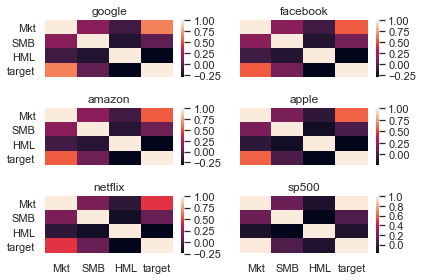

In [13]:
rows = int(math.floor(len(dataframe_collection)/2))
cols = 2
stocks = list(dataframe_collection.keys())
fig, axn = plt.subplots(rows,cols, sharex=True, sharey=True)
for i, ax in enumerate(axn.flat):
    ax.set_title(stocks[i])
    sns.heatmap(dataframe_collection[stocks[i]]['fama_french_data'].corr(), ax=ax)

fig.tight_layout()

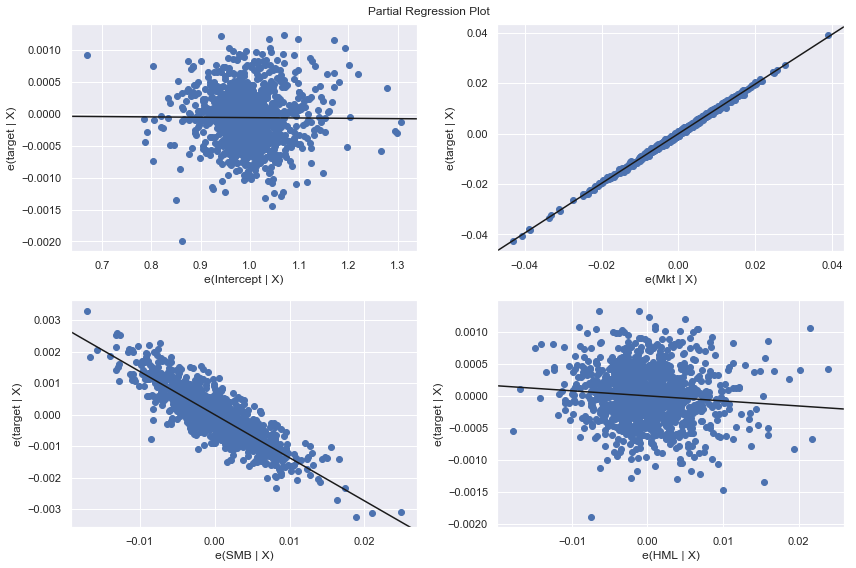

In [14]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(dataframe_collection['sp500']['fama_model'],fig=fig)

#### fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(dataframe_collection['facebook']['fama_model'],fig=fig)

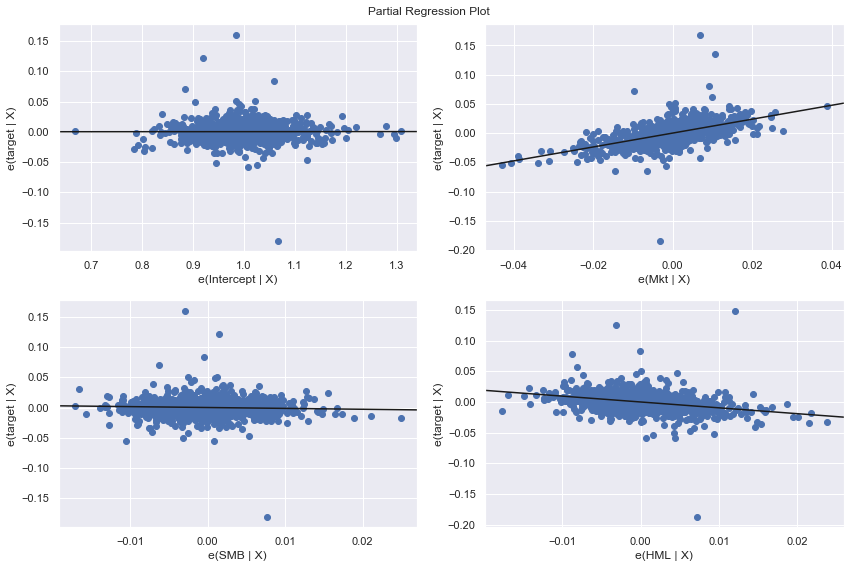

In [15]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(dataframe_collection['facebook']['fama_model'],fig=fig)

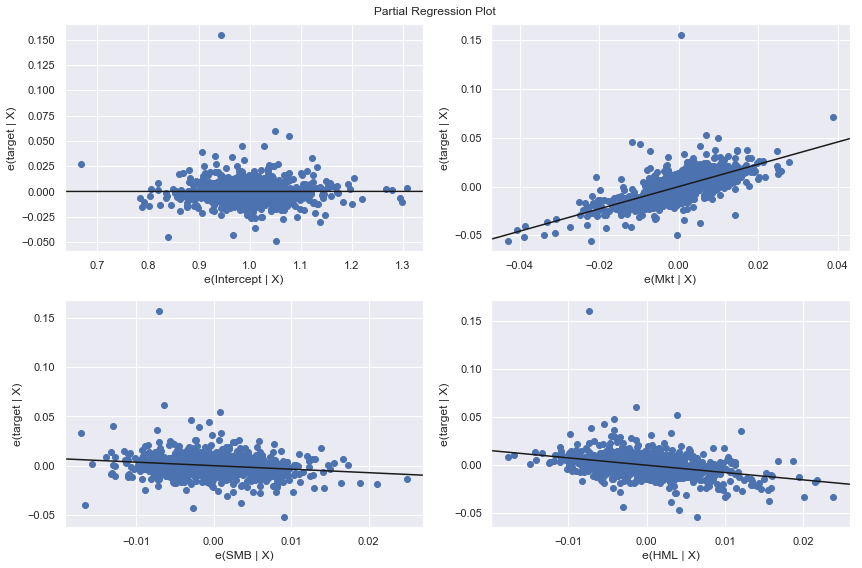

In [16]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(dataframe_collection['google']['fama_model'],fig=fig)

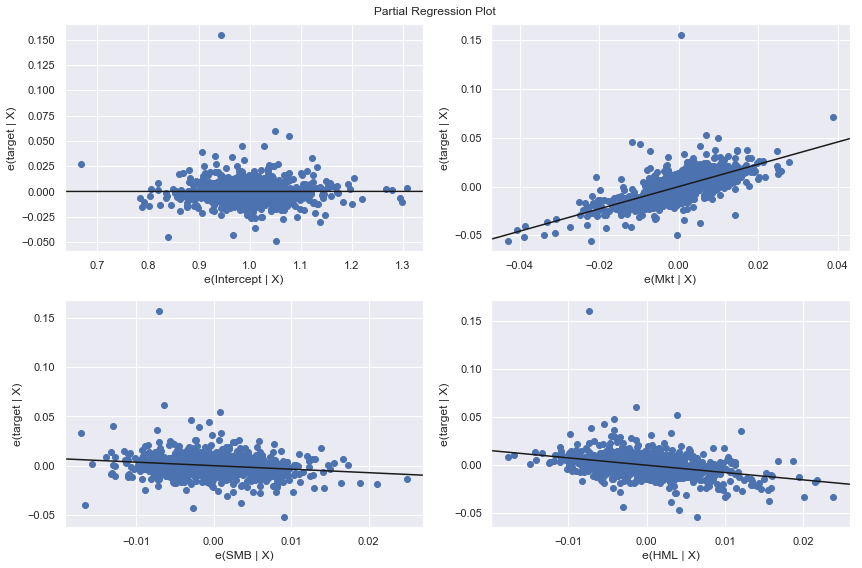

In [17]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(dataframe_collection['google']['fama_model'],fig=fig)

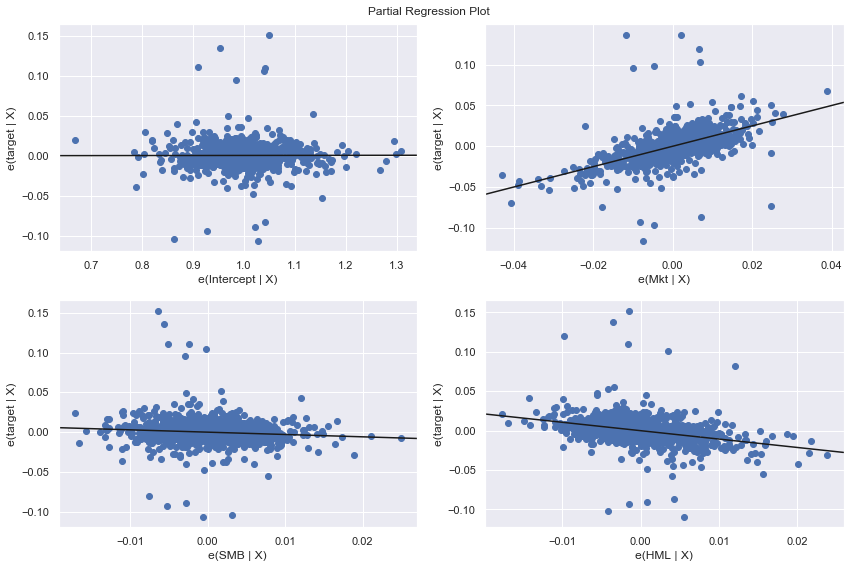

In [18]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(dataframe_collection['amazon']['fama_model'],fig=fig)

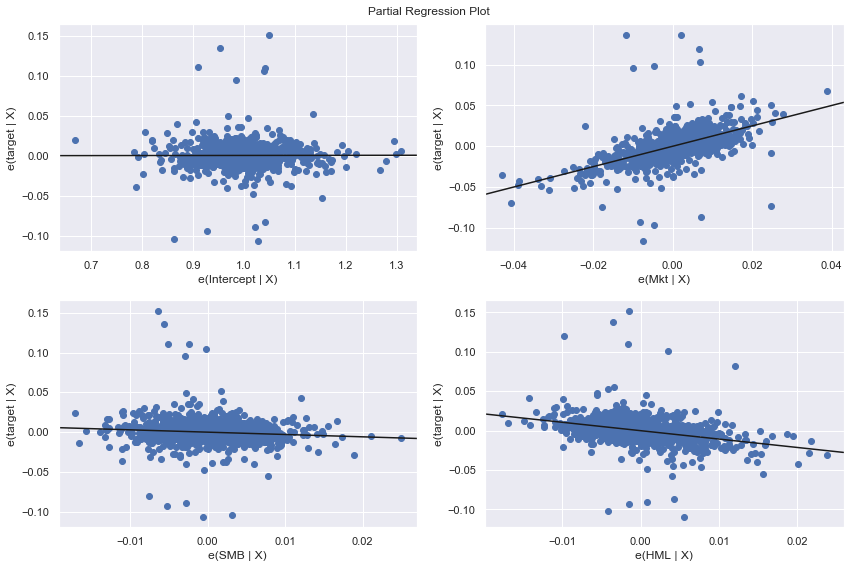

In [19]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(dataframe_collection['amazon']['fama_model'],fig=fig)

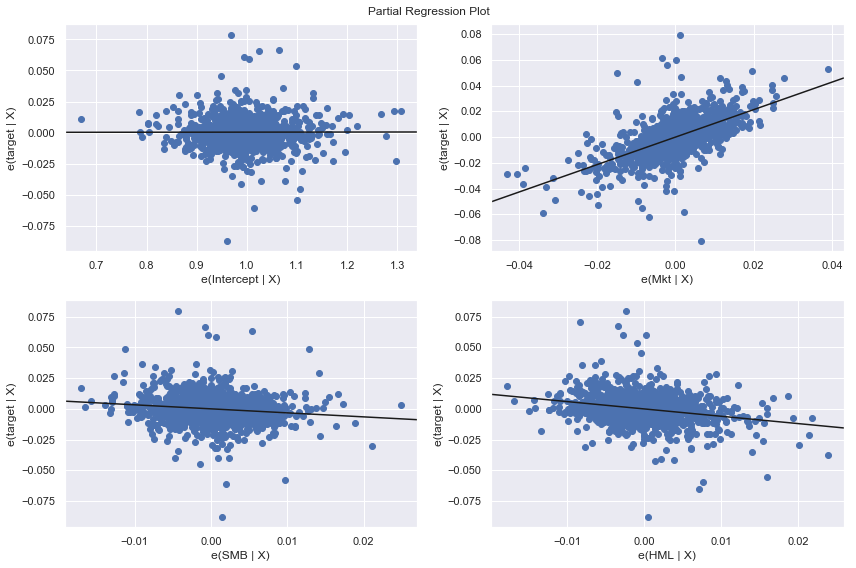

In [20]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(dataframe_collection['apple']['fama_model'],fig=fig)

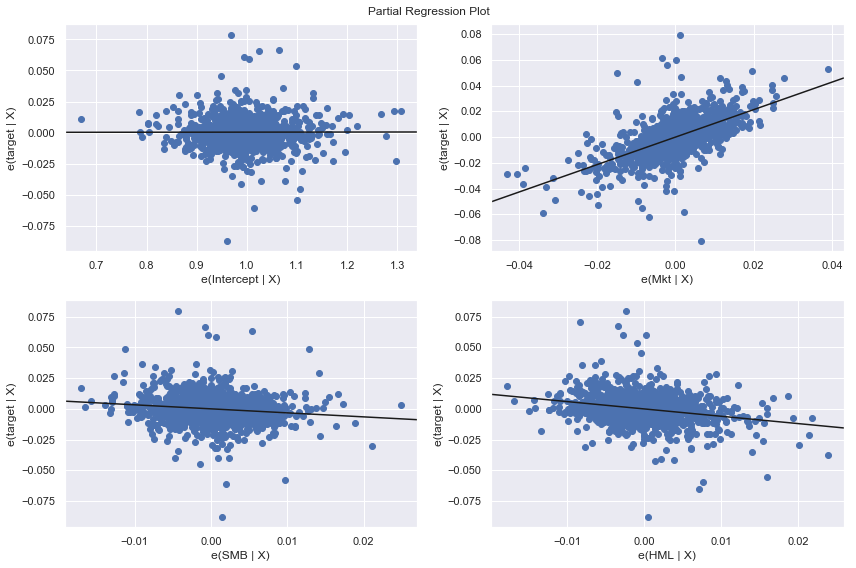

In [21]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(dataframe_collection['apple']['fama_model'],fig=fig)

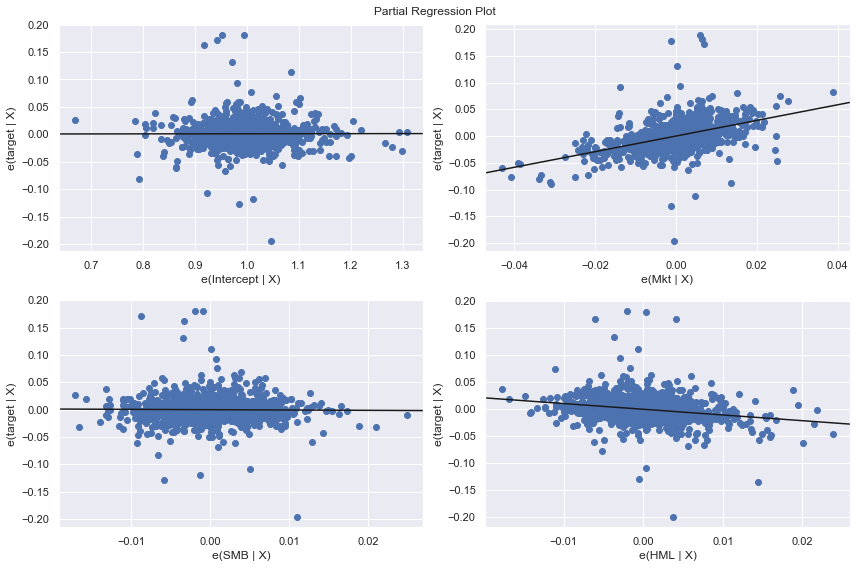

In [22]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(dataframe_collection['netflix']['fama_model'],fig=fig)

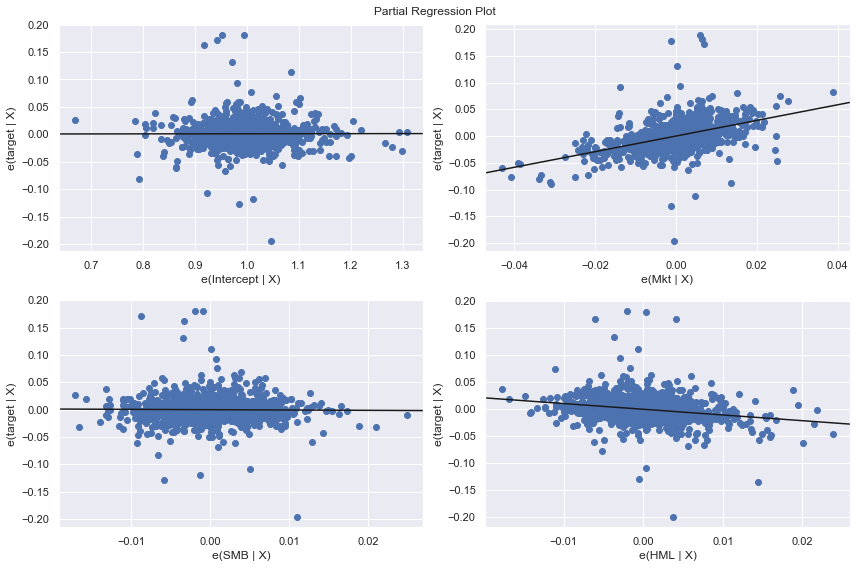

In [23]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(dataframe_collection['netflix']['fama_model'],fig=fig)